In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # For saving models
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
# Load dataset
df = pd.read_csv("/content/smart_meter_data.csv")  # Replace with actual file path

# Basic EDA
print(df.info())
print(df.describe())
print(df.isnull().sum())  # Check for missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Timestamp             5000 non-null   object 
 1   Electricity_Consumed  5000 non-null   float64
 2   Temperature           5000 non-null   float64
 3   Humidity              5000 non-null   float64
 4   Wind_Speed            5000 non-null   float64
 5   Avg_Past_Consumption  5000 non-null   float64
 6   Anomaly_Label         5000 non-null   object 
dtypes: float64(5), object(2)
memory usage: 273.6+ KB
None
       Electricity_Consumed  Temperature     Humidity   Wind_Speed  \
count           5000.000000  5000.000000  5000.000000  5000.000000   
mean               0.376677     0.525069     0.497632     0.464628   
std                0.164117     0.135603     0.146781     0.120370   
min                0.000000     0.000000     0.000000     0.000000   
25%                0.26534

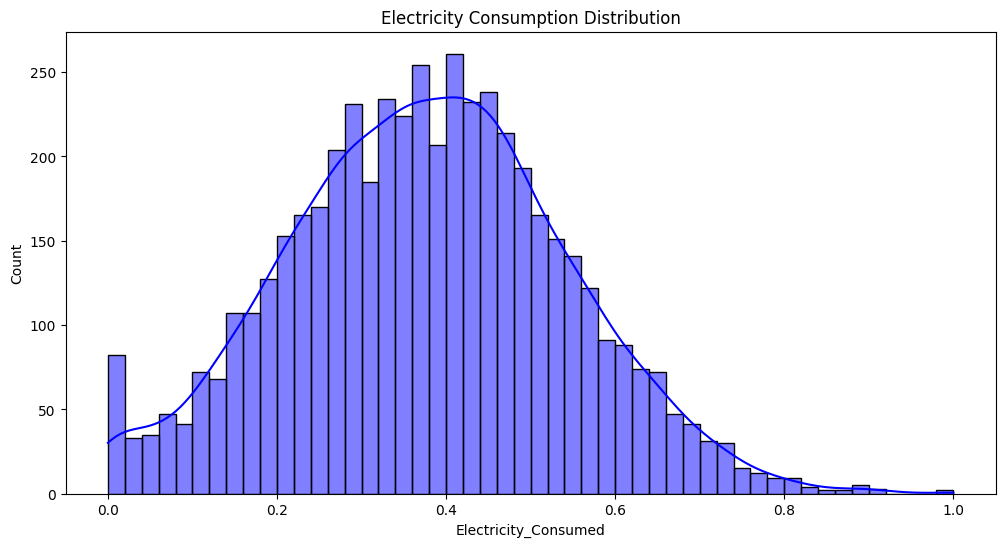

In [4]:
# Visualizing distributions
plt.figure(figsize=(12, 6))
sns.histplot(df['Electricity_Consumed'], bins=50, kde=True, color='blue')
plt.title('Electricity Consumption Distribution')
plt.show()

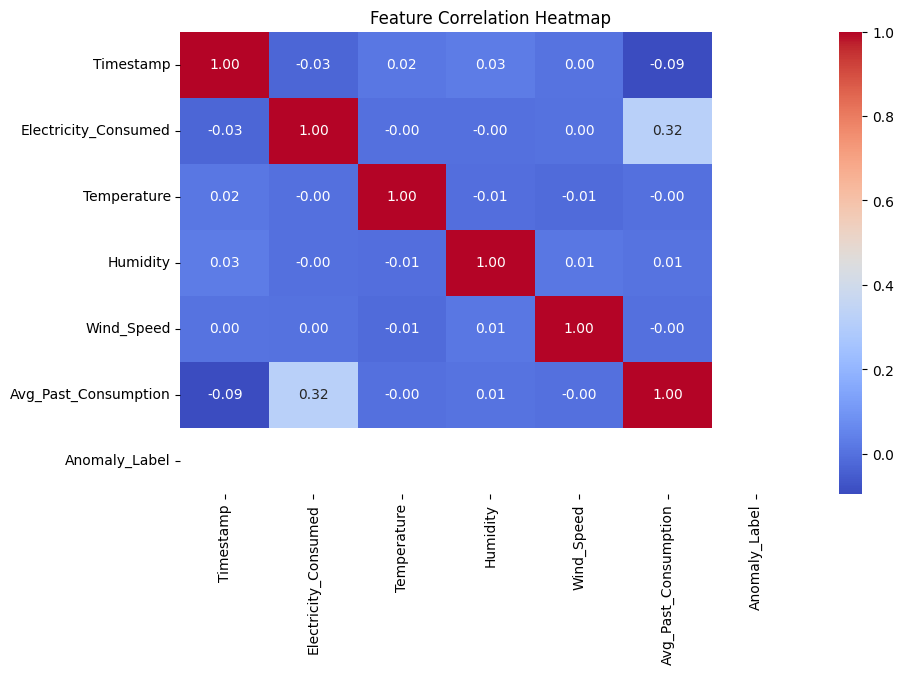

In [8]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
# Convert 'Timestamp' to numeric before calculating correlation
numeric_df = df.copy()  # Create a copy of the DataFrame to avoid modifying the original
numeric_df['Timestamp'] = pd.to_datetime(numeric_df['Timestamp']).astype(int) / 10**9  # Convert Timestamp to Unix timestamp

# Convert 'Anomaly_Label' to numeric (0 for Normal, 1 for Abnormal)
numeric_df['Anomaly_Label'] = pd.to_numeric(numeric_df['Anomaly_Label'], errors='coerce').fillna(0).astype(int)

# errors='ignore' keeps non-numeric columns as they are, but we've handled them above
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

In [9]:
# Count occurrences of each class before balancing
class_counts_before = df["Anomaly_Label"].value_counts()

In [10]:
# Convert categorical labels to numerical (if needed)
df["Anomaly_Label"] = df["Anomaly_Label"].map({"Normal": 0, "Abnormal": 1})

# Convert 'Timestamp' column to numerical (Unix timestamp)
df['Timestamp'] = pd.to_datetime(df['Timestamp']).view(int) / 10**9

<ipython-input-10-ce338d47a3c9>:5: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df['Timestamp'] = pd.to_datetime(df['Timestamp']).view(int) / 10**9


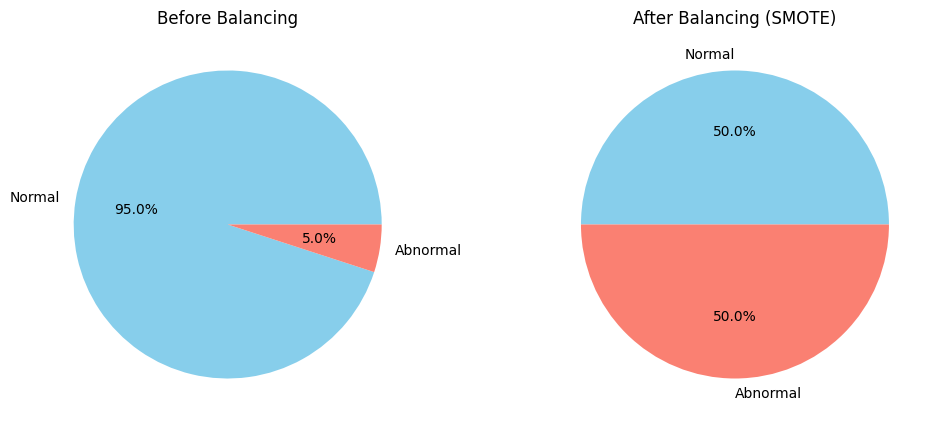

In [11]:
# Define features and target
X = df.drop(columns=["Anomaly_Label"])
y = df["Anomaly_Label"]

# Apply SMOTE for balancing
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Count occurrences after balancing
class_counts_after = pd.Series(y_resampled).value_counts()

# Plot class distribution before & after balancing
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].pie(class_counts_before, labels=["Normal", "Abnormal"], autopct='%1.1f%%', colors=['skyblue', 'salmon'])
axes[0].set_title("Before Balancing")
axes[1].pie(class_counts_after, labels=["Normal", "Abnormal"], autopct='%1.1f%%', colors=['skyblue', 'salmon'])
axes[1].set_title("After Balancing (SMOTE)")
plt.show()

In [12]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Save scaler for future use
joblib.dump(scaler, "scaler.pkl")
print("✅ Scaler saved as 'scaler.pkl'")

✅ Scaler saved as 'scaler.pkl'


In [13]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
}


In [16]:
# Train, evaluate, and save models
results = {}

for name, model in models.items():
    print(f"\n🔹 Training Model: {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    report = classification_report(y_test, y_pred, output_dict=True)

    results[name] = {
        "Accuracy": accuracy,
        "ROC-AUC": roc_auc,
        "Classification Report": report
    }
    # Save the trained model
    model_filename = f"{name.lower().replace(' ', '_')}.pkl"
    joblib.dump(model, model_filename)
    print(f"✅ Model saved as '{model_filename}'")

# Print results
for model_name, metrics in results.items():
    print(f"\n🔹 Model: {model_name}") # This line and the following lines within the loop were not indented.
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    if metrics["ROC-AUC"]:
        print(f"ROC-AUC Score: {metrics['ROC-AUC']:.4f}")
    print("Classification Report:")
    print(pd.DataFrame(metrics["Classification Report"]).T)

print("\n✅ All models have been trained and saved successfully! 🚀")


🔹 Training Model: Logistic Regression...
✅ Model saved as 'logistic_regression.pkl'

🔹 Training Model: Random Forest...
✅ Model saved as 'random_forest.pkl'

🔹 Training Model: Support Vector Machine...
✅ Model saved as 'support_vector_machine.pkl'

🔹 Training Model: XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:01:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Model saved as 'xgboost.pkl'

🔹 Training Model: K-Nearest Neighbors...
✅ Model saved as 'k-nearest_neighbors.pkl'

🔹 Model: Logistic Regression
Accuracy: 0.5500
ROC-AUC Score: 0.5698
Classification Report:
              precision    recall  f1-score  support
0              0.549428  0.555789  0.552590   950.00
1              0.550586  0.544211  0.547380   950.00
accuracy       0.550000  0.550000  0.550000     0.55
macro avg      0.550007  0.550000  0.549985  1900.00
weighted avg   0.550007  0.550000  0.549985  1900.00

🔹 Model: Random Forest
Accuracy: 0.9063
ROC-AUC Score: 0.9680
Classification Report:
              precision    recall  f1-score      support
0              0.890688  0.926316  0.908153   950.000000
1              0.923246  0.886316  0.904404   950.000000
accuracy       0.906316  0.906316  0.906316     0.906316
macro avg      0.906967  0.906316  0.906278  1900.000000
weighted avg   0.906967  0.906316  0.906278  1900.000000

🔹 Model: Support Vector Machine
Accuracy: 0.8